In [5]:
import jax
from jax import grad, jvp
import jax.numpy as jnp
from trajax import integrators

n = 8
m = 2

Mass=0.486
mass = 0.2*Mass
grav = 9.81
l = 0.25
L = 2*l
J = 0.00383
fric = 0.01
u_hover = 0.5*(Mass+mass)*grav*jnp.ones((m,))

# State: q = (p_x, p_y, theta, phi, velocities)
# where theta: rotation angle of quad
# phi: rotation angle of pendulum, w.r.t. vertical (NOTE: not a relative angle)

def get_mass_matrix(q):
  phi = q[-1]
  M_q = jnp.array([[Mass+mass, 0., 0., mass*L*jnp.cos(phi)],
                  [0., Mass+mass, 0., mass*L*jnp.sin(phi)],
                  [0., 0., J, 0.],
                  [mass*L*jnp.cos(phi), mass*L*jnp.sin(phi), 0., mass*L*L]])
  return M_q

def get_mass_matrix_from_state(x):

def get_mass_inv(q):
  phi = q[-1]
  a = Mass + mass
  b = mass*L*jnp.cos(phi)
  c = mass*L*jnp.sin(phi)
  d = mass*L*L
  den = (mass*L)**2. - a*d
  M_inv = jnp.array([[(c*c-a*d)/(a*den), -(b*c)/(a*den), 0., (b/den)],
                    [-(b*c)/(a*den), (b*b-a*d)/(a*den), 0., (c/den)],
                    [0., 0., (1./J), 0.],
                    [(b/den), (c/den), 0., -(a/den)]])
  return M_inv

kinetic = lambda q, q_dot: 0.5 * jnp.vdot(q_dot, get_mass_matrix(q) @ q_dot)
potential = lambda q: Mass*grav*q[1] + mass*grav*(q[1] - L*jnp.cos(q[-1]))
lag = lambda q, q_dot: kinetic(q, q_dot) - potential(q)
dL_dq = grad(lag, 0)

@jax.jit
def ode(x, u, t):
  del t
  q, q_dot = jnp.split(x, [4])
  # (M_q * q_ddot + M_dot * q_dot) - (dL_dq) = F_q
  M_q, M_dot = jvp(get_mass_matrix, (q,), (q_dot,))
  M_inv = get_mass_inv(q)
  torque_fric_pole = -fric * (q_dot[-1] - q_dot[-2])
  F_q = jnp.array([-jnp.sum(u)*jnp.sin(q[2]),
                   jnp.sum(u)*jnp.cos(q[2]),
                  (u[0]-u[1])*l - torque_fric_pole,
                  torque_fric_pole])
  q_ddot = M_inv @ (F_q + dL_dq(q, q_dot) - (M_dot @ q_dot))
  return jnp.concatenate((q_dot, q_ddot))

dt = 0.025
dynamics = integrators.rk4(ode, dt)

In [11]:
# simulate the dynamics
x = jnp.array([0., 0., 0., 0., 0., 0., 0., 0.])
u = jnp.array([0., 0.])
xs = []
for _ in range(100):
    x = dynamics(x, u, 0.02)
    xs.append(x)
xs = jnp.stack(xs)

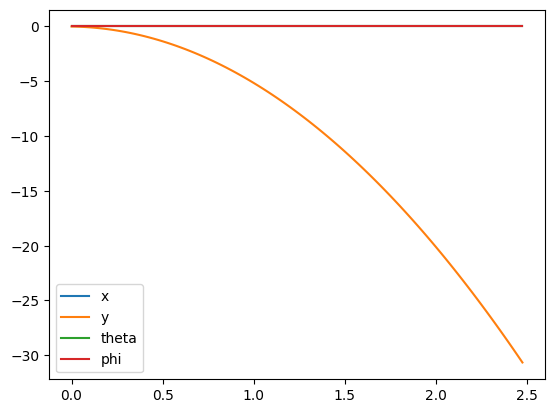

In [15]:
# plot x
import matplotlib.pyplot as plt
t = jnp.arange(0, 100*dt, dt)
plt.plot(t, xs[:, 0], label='x')
plt.plot(t, xs[:, 1], label='y')
plt.plot(t, xs[:, 2], label='theta')
plt.plot(t, xs[:, 3], label='phi')
plt.legend()